## Vamos utilizar um projeto anterior para fazermos a nossa validação ...

In [1]:

import pandas as pd
from datetime import datetime



uri = "https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv"
dados = pd.read_csv(uri)
dados.head()

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


In [2]:
# ___Tratando a tabela___

# Renomeando colunas
a_renomear = {
    'mileage_per_year' : 'milhas_por_ano',
    'model_year' : 'ano_do_modelo',
    'price' : 'preco',
    'sold' : 'vendido'
}
dados = dados.rename(columns=a_renomear)

# Resignificando informações para 0/1
a_trocar = {
    'no' : 0,
    'yes' : 1
}
dados.vendido = dados.vendido.map(a_trocar)

# Alterando formato das datas
ano_atual = datetime.today().year
dados['idade_do_modelo'] = ano_atual - dados.ano_do_modelo

# Transformando de milha/ano para Km/ano
dados['km_por_ano'] = dados.milhas_por_ano * 1.60934

# Retirando colunas que não vamos usar
dados = dados.drop(columns = ["Unnamed: 0", "milhas_por_ano","ano_do_modelo"], axis=1)


dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,20,35085.22134
1,40557.96,1,22,12622.05362
2,89627.50,0,14,11440.79806
3,95276.14,0,5,43167.32682
4,117384.68,1,6,12770.11290


In [3]:
#Importando bibliotecas para gerar modelo preditivo

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

#Biblioteca - Taxa de acerto
from sklearn.dummy import DummyClassifier

# Biblioteca - Mudança de escala
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# Biblioteca - Arvore de decisão
from sklearn.tree import DecisionTreeClassifier

# Biblioteca para fazer para plotar arvore decião
from sklearn.tree import export_graphviz
import graphviz

### Modelo 1 - Previsão linear

In [4]:
x = dados[["preco", "idade_do_modelo","km_por_ano"]]
y = dados["vendido"]

SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = LinearSVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 58.00%


C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [5]:
dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
acuracia = dummy_stratified.score(teste_x, teste_y) * 100


C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [6]:
dummy_mostfrequent = DummyClassifier()
dummy_mostfrequent.fit(treino_x, treino_y)
acuracia = dummy_mostfrequent.score(teste_x, teste_y) * 100

print("A acurácia do dummy mostfrequent foi %.2f%%" % acuracia)

A acurácia do dummy mostfrequent foi 50.68%


### Pré- processamento - Mudança de escala

In [7]:


SEED = 5
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 77.48%


### Modelo de Arvore de Decisão

In [8]:
SEED = 5
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 79.28%


### Plotando Arvore de decisão

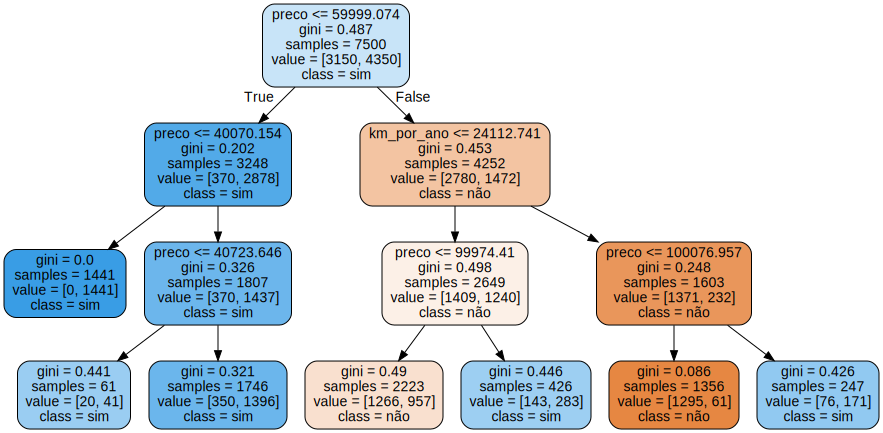

In [9]:
features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico

# _ _ _ _ _ _ _ _ _ _ _ _ _ _  VALIDAÇÃO DO MODELO _ _ _ _ _ _ _ _ _ _ _ _ _ _  

### 1- Utilizando validação cruzada

In [10]:
from sklearn.model_selection import cross_validate

# Para manter a repitibilidade dos dados.
np.random.seed(5)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x,y,cv=3 , return_train_score = False) ## cv --> quantidade de pedaços a ser quebrado

#Calculo do intervalo de scores

media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

intervalo = (media - 2*desvio_padrao)*100, (media + 2*desvio_padrao)*100


print('Accuracy com cross validation, 3 [%.2f, %.2f]' %intervalo)

Accuracy com cross validation, 3 [74.99, 76.57]


In [11]:
# Para manter a repitibilidade dos dados.
np.random.seed(5)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x,y,cv=10 , return_train_score = False) ## cv --> quantidade de pedaços a ser quebrado ( entre 5 e 10)

#Calculo do intervalo de scores

media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

intervalo = (media - 2*desvio_padrao)*100, (media + 2*desvio_padrao)*100


print('Accuracy com cross validation, 10 [%.2f, %.2f]' %intervalo)

Accuracy com cross validation, 10 [74.24, 77.32]


cv --> quantidade de pedaços a ser quebrado (entre 5 e 10) esta ótimo

### Obs: com esse método conseguimos apresentar uma taxa mais confiavel e assertiva em nossas validações. Tirando a influencia do cálculo da acuracia de variáveis randonicas

#

## KFold - Introduzindo aleatoriedade no CROSS VALIDATE

In [12]:
#Calculo do intervalo de scores

def imprime_resultados(results):
    media = results['test_score'].mean()
    desvio_padrao = results['test_score'].std()

    intervalo = (media - 2*desvio_padrao)*100, (media + 2*desvio_padrao)*100
    print('Accuracy médio: %.2f' %(media * 100))
    print('Accuracy intervalo: [%.2f, %.2f]' %intervalo)

In [13]:
# Sem shuffle ( embaralhar)

from sklearn.model_selection import KFold

cv = KFold(n_splits = 10)
np.random.seed(5)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x,y,cv=cv , return_train_score = False) 

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 75.78
Accuracy intervalo: [74.37, 77.19]


In [14]:
# Com shuffle ( embaralhar)


cv = KFold(n_splits = 10, shuffle=True) #Embaralhando as variáveis
np.random.seed(5)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x,y,cv=cv , return_train_score = False) 

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 75.78
Accuracy intervalo: [73.81, 77.75]


### Obs: Caso os dados não tenham alguma estrutura interna.. como data .. etc.. usamos um embaralhador 

## ----> Vamos $Simular$ uma situação $Ruim$.. podendo ser uma proporção desbalanciada
### Iremos pegar os valores de uma forma que não englobe totod os casos..  <---

In [15]:
dados_azar = dados.sort_values('vendido', ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]

dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,14,24812.80412
5322,84843.49,0,15,23095.63834
5319,83100.27,0,21,36240.72746
5316,87932.13,0,18,32249.56426
5315,77937.01,0,17,28414.50704


In [16]:
# Sem shuffle ( embaralhar)

cv = KFold(n_splits = 10)
np.random.seed(5)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x_azar,y_azar,cv=cv , return_train_score = False) 

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 57.84
Accuracy intervalo: [34.29, 81.39]


In [17]:
# Com shuffle ( embaralhar)


cv = KFold(n_splits = 10, shuffle=True) #Embaralhando as variáveis
np.random.seed(5)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x_azar,y_azar,cv=cv , return_train_score = False) 

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 75.79
Accuracy intervalo: [73.79, 77.79]


### OBS: o Shuffer é bom para resolver o tipo de problema criado pela coleta de dados coletado de forma  desbalanciada

# StratifiedKFold - procura balancear as classes de variáveis 

In [18]:
from sklearn.model_selection import StratifiedKFold

In [19]:
# Com shuffle com StratifiedKFold ( embaralhar)


cv = StratifiedKFold(n_splits = 10, shuffle=True) #Embaralhando as variáveis
np.random.seed(5)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x_azar,y_azar,cv=cv , return_train_score = False) 

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 75.78
Accuracy intervalo: [73.44, 78.12]


## ----------------- Vamos criar uma coluna com modelo dos carros -----------------

In [20]:
np.random.seed(SEED)
np.random.randint(-2,3, size=10000) # gera um numero inteiro entre o intervalo, e a quantidade de numeros

array([ 1, -2, -1, ..., -2, -2,  1])

In [21]:
len(dados) # tamanho da base de dados

10000

In [22]:
dados['modelo_aleatorio'] = dados.idade_do_modelo + np.random.randint(-2,3, size=10000)

In [23]:
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,20,35085.22134,19
1,40557.96,1,22,12622.05362,23
2,89627.50,0,14,11440.79806,14
3,95276.14,0,5,43167.32682,3
4,117384.68,1,6,12770.11290,7


In [24]:
dados['modelo_aleatorio'].unique()

array([19, 23, 14,  3,  7, 13, 20, 17, 21,  9, 15,  6, 22, 18, 11, 16,  8,
       10, 12, 24,  4,  2,  5,  1], dtype=int64)

In [25]:
dados.modelo_aleatorio.value_counts()

20    893
18    776
19    765
17    740
21    679
16    635
14    635
15    630
22    576
12    519
13    518
11    427
23    404
10    367
9     344
8     281
24    205
7     193
6     151
5     113
4      78
3      53
2      15
1       3
Name: modelo_aleatorio, dtype: int64

In [26]:
dados.rename(columns={'modelo_aleatorio':'modelo'}, inplace=True)

### Estimando o modelo para vida Real.. para dados inexistentes..
### Vamos separar os dados de treino e teste em grupos .. ( esse tipo de validação é boa para dados com varios grupos)

In [27]:
from sklearn.model_selection import GroupKFold  ## se adequa melhor para modelo de previsão de dados reais

In [28]:
# GroupKFold sem shuffle ( embaralhar)


cv = GroupKFold(n_splits = 10) # separa por grupos
np.random.seed(5)


modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar,y_azar, cv = cv, groups = dados.modelo, return_train_score=False) # é necessario passar a coluna a agrupar

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 75.77
Accuracy intervalo: [72.94, 78.59]


### OBS: esses algoritimos são senciveis a varios tipode de escalas na mesma base de dados..

## Cross validation com StandardScaler

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [30]:
scaler = StandardScaler()
scaler.fit(treino_x)
treino_x_escalado = scaler.transform(treino_x)
teste_x_escalado = scaler.transform(teste_x)

modelo = SVC()
modelo.fit(treino_x_escalado, treino_y)
previsoes = modelo.predict(teste_x_escalado)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A Acurácia foi de %.2f%%" % acuracia)


A Acurácia foi de 77.48%


In [31]:
# GroupKFold sem shuffle ( embaralhar)


cv = GroupKFold(n_splits = 10) # separa por grupos
np.random.seed(5)


modelo = SVC()
results = cross_validate(modelo, x_azar,y_azar, cv = cv, groups = dados.modelo, return_train_score=False) # é necessario passar a coluna a agrupar

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 77.26
Accuracy intervalo: [74.97, 79.56]


In [32]:
scaler = StandardScaler()
scaler.fit(x_azar)
x_azar_escalado = scaler.transform(x_azar)


In [33]:
# GroupKFold sem shuffle ( embaralhar)


cv = GroupKFold(n_splits = 10) # separa por grupos
np.random.seed(5)


modelo = SVC()
results = cross_validate(modelo, x_azar_escalado,y_azar, cv = cv, groups = dados.modelo, return_train_score=False) # é necessario passar a coluna a agrupar

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 76.79
Accuracy intervalo: [73.89, 79.69]


## **Vamos criar um processo de tratamento -- ele vai rodar a transformação e estimador para cada grupo

In [34]:
from sklearn.pipeline import Pipeline

In [35]:
np.random.seed(5)


scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler),('estimador',modelo)]) # ele vai rodar a transformação e estimador para cada grupo

cv = GroupKFold(n_splits = 10) # separa por grupos
modelo = SVC()
results = cross_validate(pipeline, x_azar,y_azar, cv = cv, groups = dados.modelo, return_train_score=False) # é necessario passar a coluna a agrupar

#Calculo do intervalo de scores
imprime_resultados(results)

Accuracy médio: 76.77
Accuracy intervalo: [73.82, 79.72]


## Para rodar algoritimos com corss validação que possuam pré-processamento, é necessario rodar dentro de um pipeline

### dessa forma ele vai transformar a escala e ajudar as variaveis para cada grupo